In [38]:
import pandas as pd
import numpy as np
import os
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import seaborn as sns
import gc

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [39]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [40]:
def load_and_prepare_data():
    """Load and prepare data with memory optimizations"""
    print("Loading data...")
    df = pq.read_table('air_quality_2024_preproccessed.parquet').to_pandas()
    print(f"Dataset shape: {df.shape}")
    
    # 1. Encode location
    le_location = LabelEncoder()
    df['location_encoded'] = le_location.fit_transform(df['location'])
    
    # 2. Sort data for each location by time
    df = df.sort_values(['location_encoded', 'month', 'day', 'hour'])
    
    # 3. Select features
    feature_columns = [col for col in df.columns if col not in [
        'class', 'location', 'month', 'day', 'hour', 'location_encoded'
    ]]
    feature_columns.append('location_encoded')
    
    print(f"Feature columns: {feature_columns}")
    print(f"Number of features: {len(feature_columns)}")
    
    return df, feature_columns, le_location

In [41]:
def create_sequences_memory_efficient(df, feature_columns, sequence_length=168, stride=24):
    """Create sequences with memory optimizations"""
    print("Creating sequences with memory optimizations...")
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df[feature_columns])
    X_scaled = pd.DataFrame(X_scaled, columns=feature_columns, index=df.index)
    
    X_sequences = []
    y_sequences = []
    location_indices = []
    
    unique_locations = df['location_encoded'].unique()
    
    for i, loc in enumerate(unique_locations):
        loc_df = df[df['location_encoded'] == loc]
        loc_X = X_scaled.loc[loc_df.index]
        loc_y = loc_df['class'].values
        
        # Use stride to reduce number of sequences
        for j in range(0, len(loc_df) - sequence_length, stride):
            X_seq = loc_X.iloc[j:j+sequence_length].values
            y_seq = loc_y[j+1:j+1+72]
            
            if len(y_seq) == 72:
                X_sequences.append(X_seq)
                y_sequences.append(y_seq)
                location_indices.append(loc)
        
        # Print progress and free memory
        if i % 10 == 0:
            print(f"Processed location {i}/{len(unique_locations)}")
            gc.collect()  # Force garbage collection
    
    X_sequences = np.array(X_sequences)
    y_sequences = np.array(y_sequences)
    location_indices = np.array(location_indices)
    
    print(f"Total sequences: {X_sequences.shape[0]}")
    print(f"Sequence shape: {X_sequences.shape}")
    print(f"Target shape: {y_sequences.shape}")
    print(f"Memory usage: {X_sequences.nbytes / 1024**3:.2f} GB")
    
    return X_sequences, y_sequences, location_indices, scaler

In [42]:
def build_model(sequence_length, n_features):
    """Build a memory-efficient LSTM model"""
    input_shape = (sequence_length, n_features)
    inputs = Input(shape=input_shape)
    
    x = LSTM(32, return_sequences=True)(inputs)  # Reduced from 64
    x = Dropout(0.3)(x)
    x = LSTM(16, return_sequences=True)(x)  # Reduced from 32
    x = Dropout(0.2)(x)
    
    # Take only the first 72 timesteps from the output
    x = x[:, :72, :]  # Shape: (None, 72, 16)
    outputs = Dense(1, activation='sigmoid')(x)  # Shape: (None, 72, 1)
    
    model = Model(inputs, outputs)
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    
    return model

In [43]:
def train_model(X_train, y_train, X_test, y_test, sequence_length, n_features):
    """Train the model with memory optimizations"""
    print("Building and training model...")
    
    model = build_model(sequence_length, n_features)
    model.summary()
    
    # Callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, min_lr=1e-5)
    
    # Train with smaller batch size
    history = model.fit(
        X_train,
        y_train[..., np.newaxis],
        validation_data=(X_test, y_test[..., np.newaxis]),
        epochs=10,
        batch_size=16,  # Reduced batch size
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )
    
    return model, history

In [44]:
def make_predictions(model, df, scaler, feature_columns, le_location, sequence_length=72):
    """Make predictions efficiently"""
    print("Making predictions...")
    
    predictions = []
    location_names = le_location.inverse_transform(df['location_encoded'].unique())
    
    for i, (loc_enc, loc_name) in enumerate(zip(df['location_encoded'].unique(), location_names)):
        loc_df = df[df['location_encoded'] == loc_enc]
        loc_X = scaler.transform(loc_df[feature_columns])
        
        if len(loc_X) >= sequence_length:
            last_X_seq = loc_X[-sequence_length:][np.newaxis, ...]
            pred = model.predict(last_X_seq, verbose=0)
            pred_class = (pred[0, :, 0] > 0.5).astype(int)
            
            for hour_idx in range(72):
                predictions.append({
                    'location': loc_name,
                    'hour_ahead': hour_idx + 1,
                    'predicted_class': int(pred_class[hour_idx])
                })
        
        # Print progress
        if i % 10 == 0:
            print(f"Predicted for location {i}/{len(df['location_encoded'].unique())}")
    
    return pd.DataFrame(predictions)

In [45]:
def plot_training_history(history):
    """Plot training history"""
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

Loading data...
Dataset shape: (3513600, 9)
Feature columns: ['PM25_ug_m3', 'PM25_MERRA2', 'DUSMASS25', 'DUSMASS', 'location_encoded']
Number of features: 5
Creating sequences with memory optimizations...
Processed location 0/400
Processed location 10/400
Processed location 20/400
Processed location 30/400
Processed location 40/400
Processed location 50/400
Processed location 60/400
Processed location 70/400
Processed location 80/400
Processed location 90/400
Processed location 100/400
Processed location 110/400
Processed location 120/400
Processed location 130/400
Processed location 140/400
Processed location 150/400
Processed location 160/400
Processed location 170/400
Processed location 180/400
Processed location 190/400
Processed location 200/400
Processed location 210/400
Processed location 220/400
Processed location 230/400
Processed location 240/400
Processed location 250/400
Processed location 260/400
Processed location 270/400
Processed location 280/400
Processed location 290/

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 168, 5)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 168, 32)        │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 168, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 168, 16)        │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 168, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ get_item_1 (GetItem)            │ (None, 72, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 72, 1)          │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,017 (31.32 KB)

 Trainable params: 8,017 (31.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
8078/8078 ━━━━━━━━━━━━━━━━━━━━ 268s 33ms/step - accuracy: 0.9653 - loss: 0.0955 - val_accuracy: 0.9760 - val_loss: 0.0667 - learning_rate: 0.0010
Epoch 2/10
8078/8078 ━━━━━━━━━━━━━━━━━━━━ 272s 34ms/step - accuracy: 0.9753 - loss: 0.0682 - val_accuracy: 0.9771 - val_loss: 0.0618 - learning_rate: 0.0010
Epoch 3/10
8078/8078 ━━━━━━━━━━━━━━━━━━━━ 255s 32ms/step - accuracy: 0.9764 - loss: 0.0647 - val_accuracy: 0.9781 - val_loss: 0.0590 - learning_rate: 0.0010
Epoch 4/10
8078/8078 ━━━━━━━━━━━━━━━━━━━━ 248s 31ms/step - accuracy: 0.9770 - loss: 0.0628 - val_accuracy: 0.9784 - val_loss: 0.0576 - learning_rate: 0.0010
Epoch 5/10
8078/8078 ━━━━━━━━━━━━━━━━━━━━ 247s 31ms/step - accuracy: 0.9773 - loss: 0.0615 - val_accuracy: 0.9783 - val_loss: 0.0575 - learning_rate: 0.0010
Epoch 6/10
8078/8078 ━━━━━━━━━━━━━━━━━━━━ 247s 31ms/step - accuracy: 0.9775 - loss: 0.0606 - val_accuracy: 0.9789 - val_loss: 0.0564 - learning_rate: 0.0010
Epoch 7/10
8078/8078 ━━━━━━━━━━━━━━━━━━━━ 248s 31ms/step -

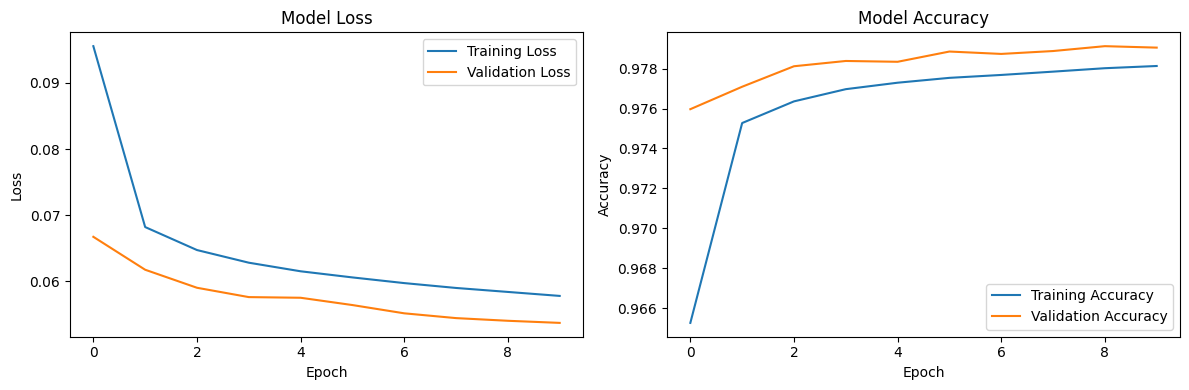

Training completed successfully!


In [46]:
try:
    # Load and prepare data
    df, feature_columns, le_location = load_and_prepare_data()
    
    # Create sequences
    X_sequences, y_sequences, location_indices, scaler = create_sequences_memory_efficient(
        df, feature_columns, sequence_length=168, stride=24
    )
    
    # Convert targets
    y_sequences = y_sequences.astype(int)
    
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_sequences, y_sequences, test_size=0.1, random_state=42, stratify=location_indices
    )
    
    print(f"Training set: {X_train.shape}")
    print(f"Test set: {X_test.shape}")
    
    # Free memory
    del X_sequences, y_sequences, location_indices
    gc.collect()
    
    # Train model
    model, history = train_model(
        X_train, y_train, X_test, y_test, 
        sequence_length=168, n_features=len(feature_columns)
    )
    
    # Make predictions
    predictions_df = make_predictions(
        model, df, scaler, feature_columns, le_location, sequence_length=168
    )
    
    # Save results
    predictions_df.to_csv('lstm_predictions.csv', index=False)
    print("Predictions saved to lstm_predictions.csv")
    
    # Plot history
    plot_training_history(history)
    
    print("Training completed successfully!")
    
except Exception as e:
    print(f"Error occurred: {e}")
    import traceback
    traceback.print_exc()